# RANZCR_EfB4_CV_Tr
![](https://storage.googleapis.com/kaggle-competitions/kaggle/23870/logos/header.png?t=2020-12-01-04-28-05)

Serious complications can occur as a result of malpositioned lines and tubes in patients. Doctors and nurses frequently use checklists for placement of lifesaving equipment to ensure they follow protocol in managing patients. Yet, these steps can be time consuming and are still prone to human error, especially in stressful situations when hospitals are at capacity.

Hospital patients can have catheters and lines inserted during the course of their admission and serious complications can arise if they are positioned incorrectly. Nasogastric tube malpositioning into the airways has been reported in up to 3% of cases, with up to 40% of these cases demonstrating complications [1-3]. Airway tube malposition in adult patients intubated outside the operating room is seen in up to 25% of cases [4,5]. The likelihood of complication is directly related to both the experience level and specialty of the proceduralist. Early recognition of malpositioned tubes is the key to preventing risky complications (even death), even more so now that millions of COVID-19 patients are in need of these tubes and lines.

The gold standard for the confirmation of line and tube positions are chest radiographs. However, a physician or radiologist must manually check these chest x-rays to verify that the lines and tubes are in the optimal position. Not only does this leave room for human error, but delays are also common as radiologists can be busy reporting other scans. Deep learning algorithms may be able to automatically detect malpositioned catheters and lines. Once alerted, clinicians can reposition or remove them to avoid life-threatening complications.

In [1]:
!pip install efficientnet -q

In [2]:
import efficientnet.tfkeras as efn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception, InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from kaggle_datasets import KaggleDatasets
import tensorflow_addons as tfa

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, ast, math, gc
from PIL import Image

In [4]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


## Functions
I'm thankful to **xhlulu** for useful functions and methods of working with TPU ([RANZCR: EfficientNet B3 GPU Starter](https://www.kaggle.com/xhlulu/ranzcr-efficientnet-b3-gpu-starter))

## Work directory

In [5]:
WORK_DIR = '../input/ranzcr-clip-catheter-line-classification'
os.listdir(WORK_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'train_annotations.csv',
 'test_tfrecords',
 'train.csv',
 'test',
 'train']

# Fast look at the data

In [6]:
print('Train images: %d' %len(os.listdir(os.path.join(WORK_DIR, "train"))))

Train images: 30083


In [7]:
# Data
GCS_DS_PATH = KaggleDatasets().get_gcs_path('ranzcr-clip-catheter-line-classification')

train = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_images = GCS_DS_PATH + "/train/" + train['StudyInstanceUID'] + '.jpg'

ss = pd.read_csv(os.path.join(WORK_DIR, 'sample_submission.csv'))
test_images = GCS_DS_PATH + "/test/" + ss['StudyInstanceUID'] + '.jpg'

label_cols = ss.columns[1:]
labels = train[label_cols].values

train_annot = pd.read_csv(os.path.join(WORK_DIR, "train_annotations.csv"))

print('Labels:\n', '*'*20, '\n', label_cols.values)
print('*'*50)
train.head()

Labels:
 ******************** 
 ['ETT - Abnormal' 'ETT - Borderline' 'ETT - Normal' 'NGT - Abnormal'
 'NGT - Borderline' 'NGT - Incompletely Imaged' 'NGT - Normal'
 'CVC - Abnormal' 'CVC - Borderline' 'CVC - Normal'
 'Swan Ganz Catheter Present']
**************************************************


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


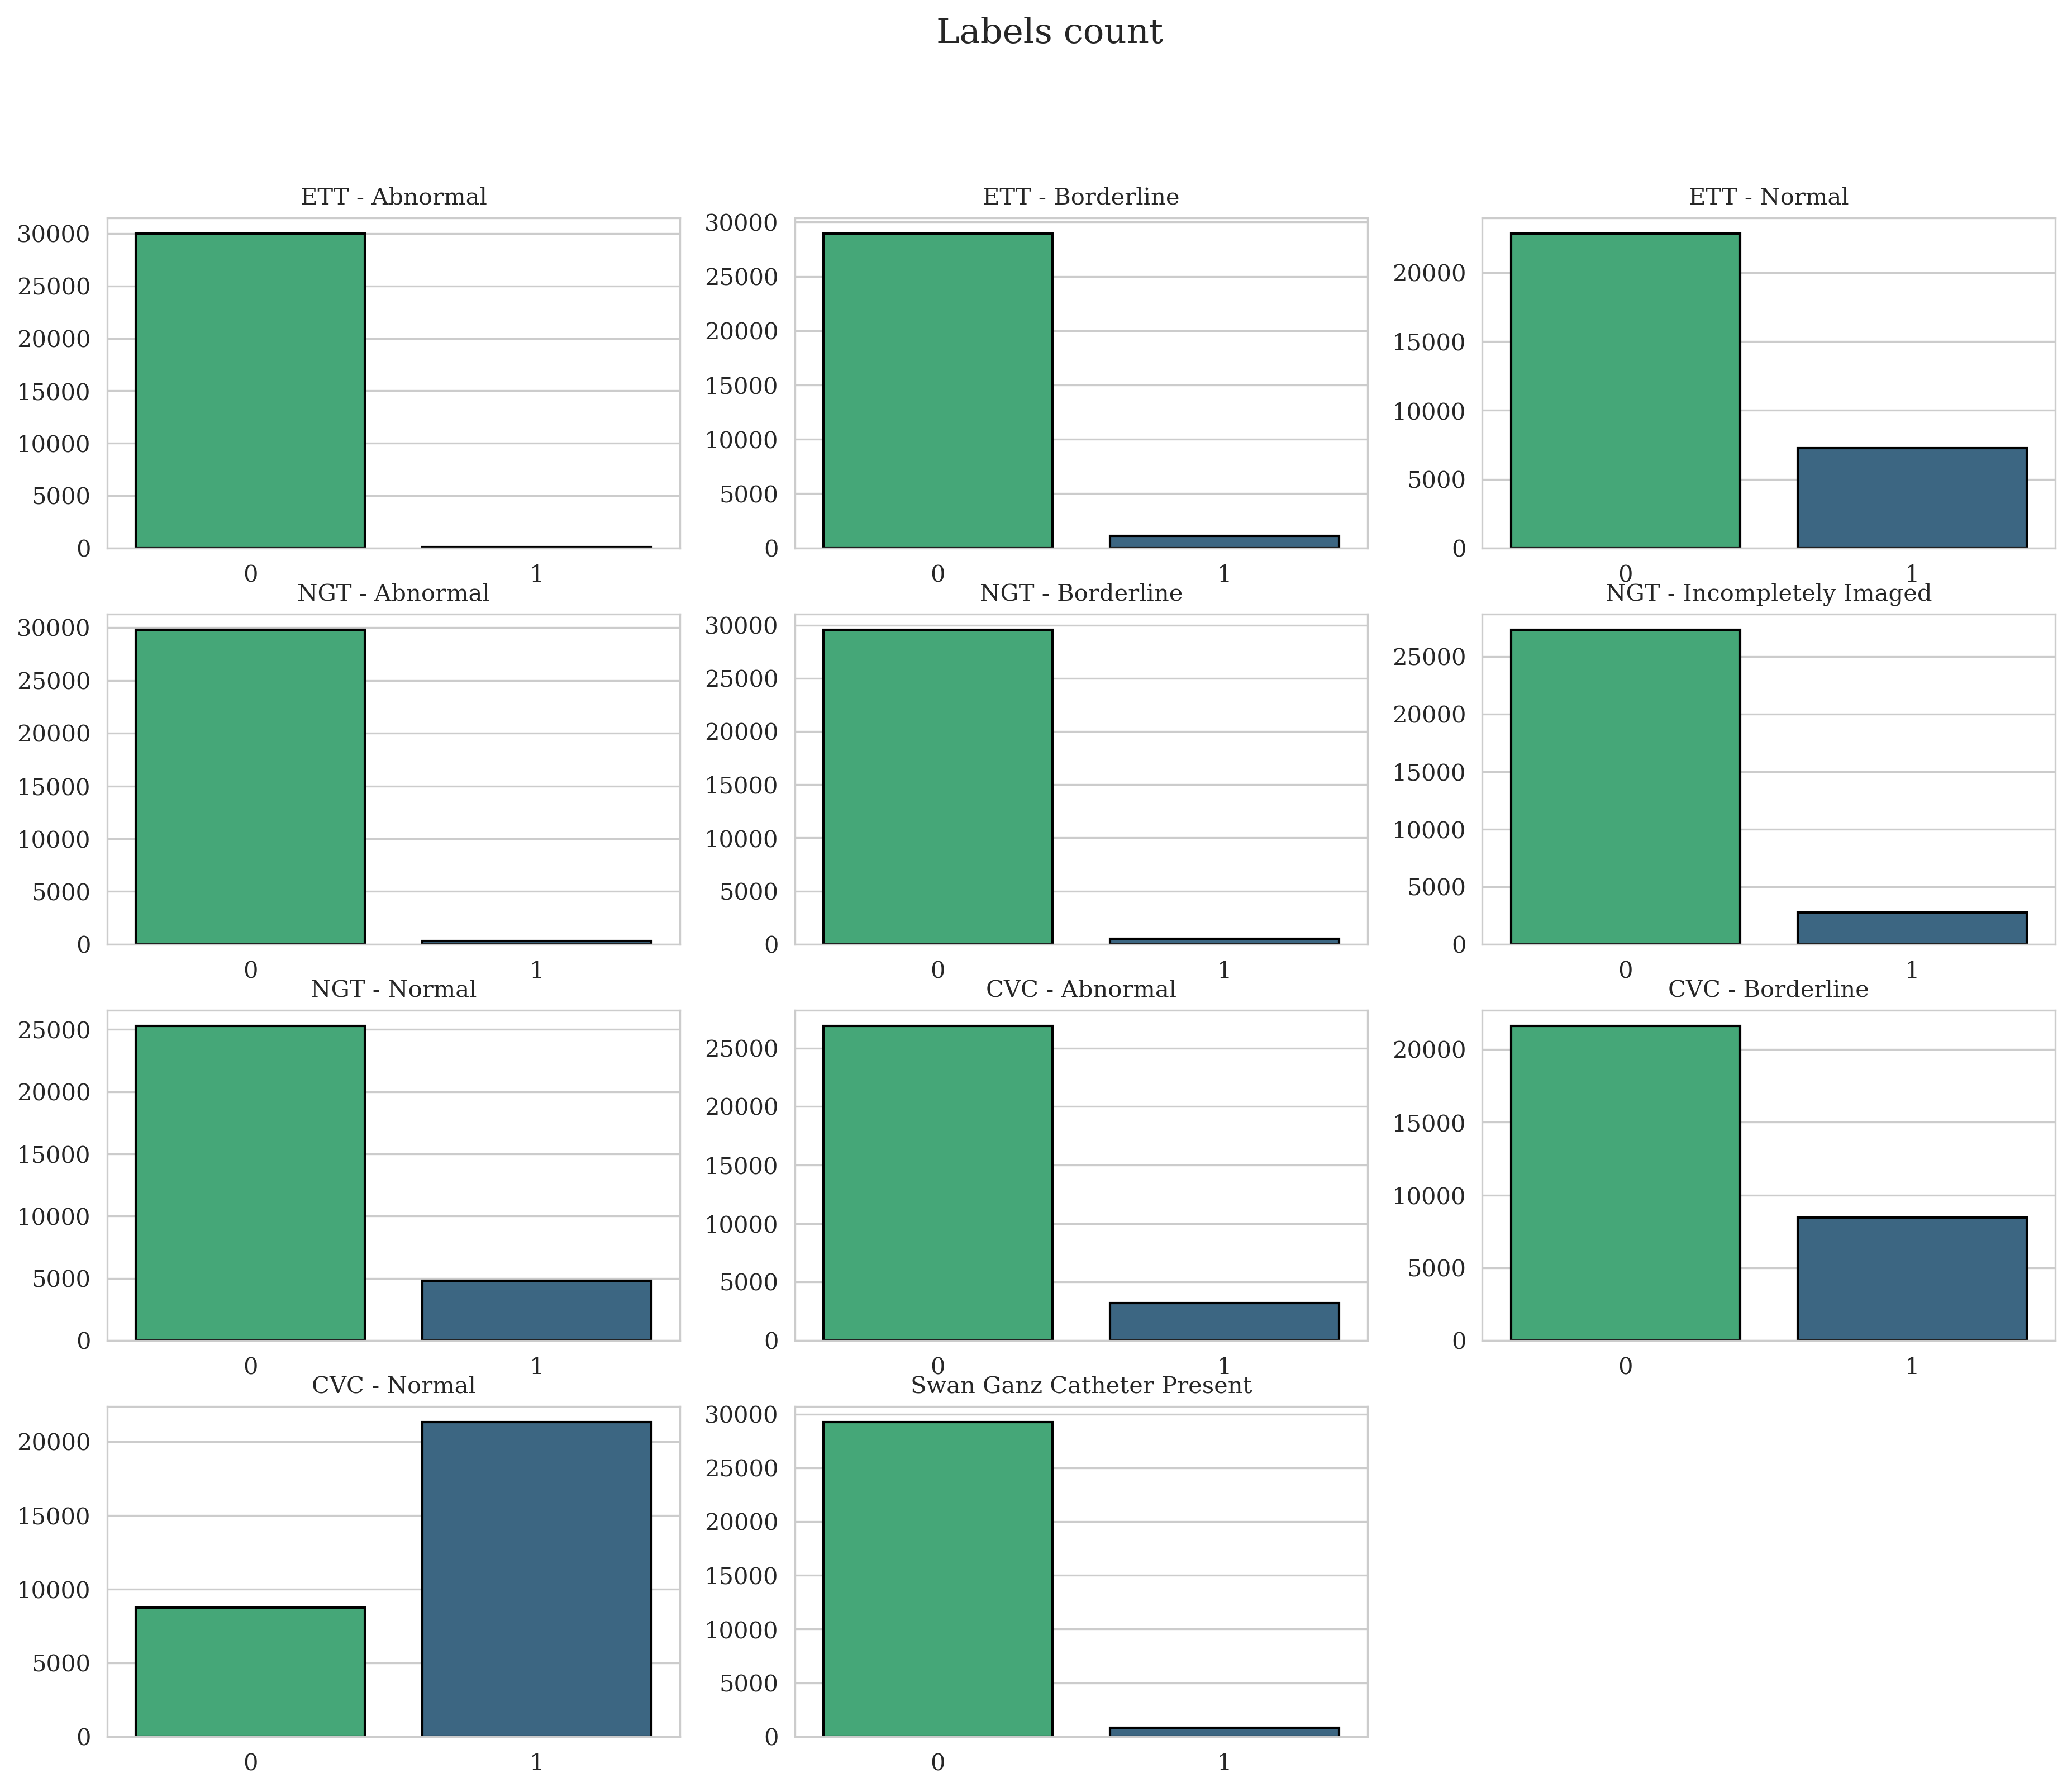

In [8]:
sns.set_style("whitegrid")
fig = plt.figure(figsize = (15, 12), dpi = 300)
plt.suptitle('Labels count', fontfamily = 'serif', size = 15)

for ind, i in enumerate(label_cols):
    fig.add_subplot(4, 3, ind + 1)

    sns.countplot(train[i], edgecolor = 'black',
                  palette = reversed(sns.color_palette('viridis', 2)))
    
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontfamily = 'serif', size = 10)
    plt.yticks(fontfamily = 'serif', size = 10)
    plt.title(i, fontfamily = 'serif', size = 10)
plt.show()

## Some images

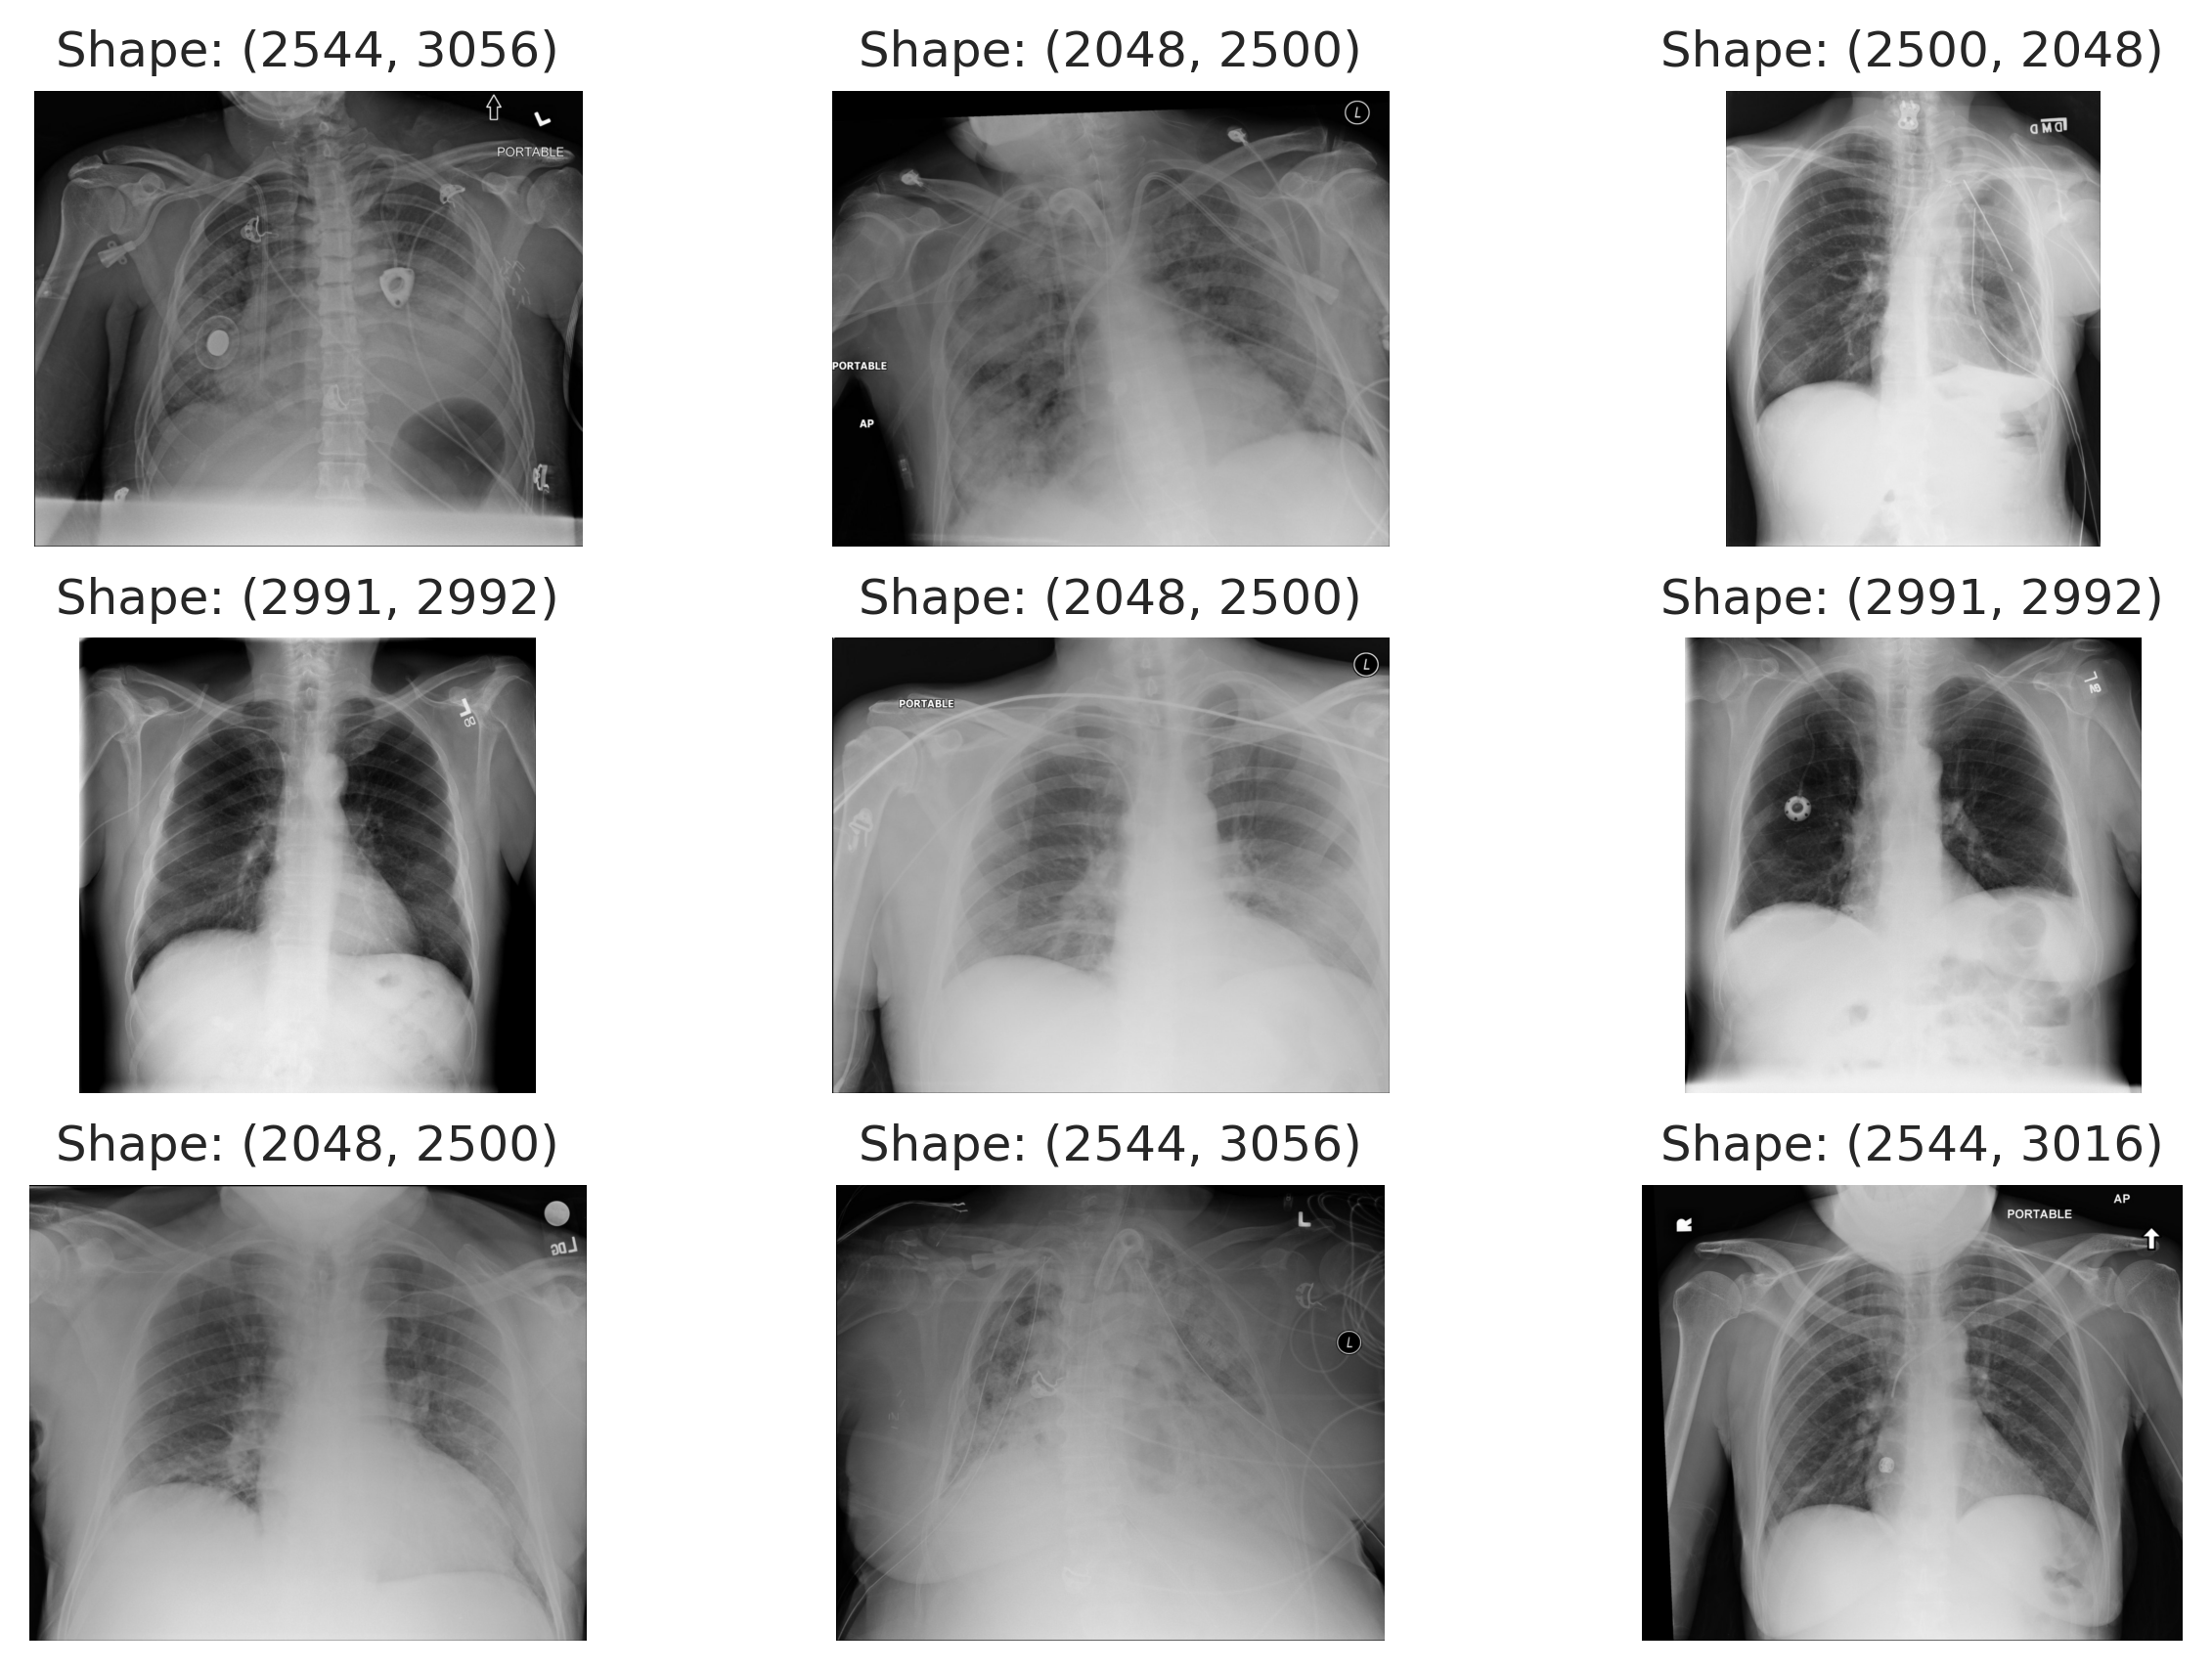

In [9]:
sample = train.sample(9)
plt.figure(figsize=(10, 7), dpi = 300)
for ind, image_id in enumerate(sample.StudyInstanceUID):
    plt.subplot(3, 3, ind + 1)
    image = image_id + '.jpg'
    img = cv2.imread(os.path.join(WORK_DIR, "train", image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Shape: {}'.format(img.shape[:2]))
    plt.axis("off")
plt.show()

# Preparation for modeling

In [10]:
# Main parameters
BATCH_SIZE = 8 * REPLICAS
STEPS_PER_EPOCH = len(train) * (1 / 7 * 6) / BATCH_SIZE
VALIDATION_STEPS = len(train) * (1 / 7 * 1) / BATCH_SIZE
EPOCHS = 30
TARGET_SIZE = 550

In [11]:
def build_decoder(with_labels = True,
                  target_size = (TARGET_SIZE, TARGET_SIZE), 
                  ext = 'jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels = 3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels = 3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels = True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        
        p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
        p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
        p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
        p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
#         p_crop = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
        
        if p_rotate > .75:
            img = tf.image.rot90(img, k = 3) # rotate 270º
        elif p_rotate > .5:
            img = tf.image.rot90(img, k = 2) # rotate 180º
        elif p_rotate > .25:
            img = tf.image.rot90(img, k = 1) # rotate 90º
            
        if p_pixel_1 >= .6:
            img = tf.image.random_saturation(img, lower = 0.75, upper = 1.25)
        if p_pixel_2 >= .6:
            img = tf.image.random_contrast(img, lower = 0.75, upper = 1.25)
        if p_pixel_3 >= .4:
            img = tf.image.random_brightness(img, max_delta = 0.1)
        
#         if p_crop > .7:
#             if p_crop > .9:
#                 img = tf.image.central_crop(img, central_fraction=.75)
#             elif p_crop > .8:
#                 img = tf.image.central_crop(img, central_fraction=.85)
#             else:
#                 img = tf.image.central_crop(img, central_fraction=.95)
#         elif p_crop > .4:
#             crop_size = tf.random.uniform([], int(TARGET_SIZE * .85), TARGET_SIZE, dtype = tf.int32)
#             img = tf.image.random_crop(img, size = [crop_size, crop_size, 3])
        
#         img = tf.image.resize(img, size = [TARGET_SIZE, TARGET_SIZE])
        
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels = None, bsize = 32, cache = True,
                  decode_fn = None, augment_fn = None,
                  augment = True, repeat = True, shuffle = 1024, 
                  cache_dir = ""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls = AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls = AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

In [12]:
# test_df = build_dataset(
#     test_images, bsize = BATCH_SIZE, repeat = False, 
#     shuffle = False, augment = False, cache = False)

In [13]:
# #Train test split
# (train_img, valid_img, 
#  train_labels, valid_labels) = train_test_split(train_images, labels, 
#                                                 train_size = 0.85, 
#                                                 random_state = 0)

In [14]:
# # Tensorflow datasets
# train_df = build_dataset(
#     train_img, tf.cast(train_labels, tf.float32), bsize = BATCH_SIZE, 
#     cache = True)

# valid_df = build_dataset(
#     valid_img, tf.cast(valid_labels, tf.float32), bsize = BATCH_SIZE, 
#     repeat = False, shuffle = False, augment = False, 
#     cache = True)

test_df = build_dataset(
    test_images, bsize = BATCH_SIZE, repeat = False, 
    shuffle = False, augment = False, cache = False)

In [15]:
test_df

<PrefetchDataset shapes: (None, 550, 550, 3), types: tf.float32>

# Training

In [16]:
def create_model():
    conv_base = efn.EfficientNetB4(include_top = False, weights = 'imagenet',
                                   input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dropout(0.5)(model)
    model = layers.Dense(11, activation = "sigmoid")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.0002),
                  loss = tfa.losses.SigmoidFocalCrossEntropy(alpha = 0.5, gamma = 2),
                  metrics = [tf.keras.metrics.AUC(multi_label = True)])
    return model

In [17]:
FOLDS = 7
kf = KFold(n_splits = FOLDS, shuffle = True, random_state = 0)
history_list = []

for fold, (t_ind, v_ind) in enumerate(kf.split(train_images)):
    print('*'*50)
    print(f'FOLD: {fold + 1}')
    print('*'*50)
    
    # Tensorflow datasets
    train_df = build_dataset(
        train_images[t_ind], tf.cast(labels[t_ind], tf.float32), 
        bsize = BATCH_SIZE, 
        cache = True)

    valid_df = build_dataset(
        train_images[v_ind], tf.cast(labels[v_ind], tf.float32), 
        bsize = BATCH_SIZE, 
        repeat = False, shuffle = False, augment = False, 
        cache = True)
    
    # Training
    tf.keras.backend.clear_session()
    with strategy.scope():
        model = create_model()

    
    early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                               patience = 5, mode = 'min', verbose = 1,
                               restore_best_weights = True)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, 
                                  patience = 2, min_delta = 0.0001, 
                                  mode = 'min', verbose = 1)
    
    history = model.fit(
        train_df,
        epochs = EPOCHS,
        steps_per_epoch = STEPS_PER_EPOCH,
        validation_data = valid_df,
        validation_steps = VALIDATION_STEPS,
        callbacks = [early_stop, reduce_lr]
    )
    
    history_list.append(history)
    
    model_name = f'EfB4_550_{fold}.h5'
    model.save(model_name)
    
    # Prediction
    ss[label_cols] += model.predict(test_df) / FOLDS
    
    del train_df, valid_df, model
    gc.collect()
    
    print('*'*50)
    print('*'*50)

**************************************************
FOLD: 1
**************************************************
71892992/71892840 [==============================] - 1s 0us/step
Epoch 1/30
402/402 [==============================] - 1172s 3s/step - loss: 0.4304 - auc: 0.6937 - val_loss: 0.3164 - val_auc: 0.8181
Epoch 2/30
402/402 [==============================] - 167s 415ms/step - loss: 0.3201 - auc: 0.8081 - val_loss: 0.2751 - val_auc: 0.8630
Epoch 3/30
402/402 [==============================] - 168s 416ms/step - loss: 0.2962 - auc: 0.8383 - val_loss: 0.2569 - val_auc: 0.8880
Epoch 4/30
402/402 [==============================] - 168s 417ms/step - loss: 0.2774 - auc: 0.8653 - val_loss: 0.2369 - val_auc: 0.9066
Epoch 5/30
402/402 [==============================] - 167s 415ms/step - loss: 0.2573 - auc: 0.8942 - val_loss: 0.2273 - val_auc: 0.9223
Epoch 6/30
402/402 [==============================] - 168s 416ms/step - loss: 0.2453 - auc: 0.9101 - val_loss: 0.2309 - val_auc: 0.9274
Epoch 7/30


In [18]:
ss.to_csv('submission.csv', index = False)
ss.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0.108295,0.356000,0.597717,0.060112,0.091430,0.172321,0.822432,0.184673,0.331780,0.779616,0.967739
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0.014199,0.019720,0.009603,0.014639,0.026774,0.018387,0.013783,0.095239,0.118834,0.885185,0.012394
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0.021903,0.037957,0.035520,0.033544,0.032214,0.029727,0.042847,0.140376,0.421376,0.646675,0.016253
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0.125614,0.308902,0.443159,0.220238,0.165672,0.776971,0.139481,0.380686,0.316801,0.537162,0.121092
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0.017801,0.037446,0.052279,0.030975,0.044496,0.036810,0.065982,0.113649,0.337273,0.780231,0.014871


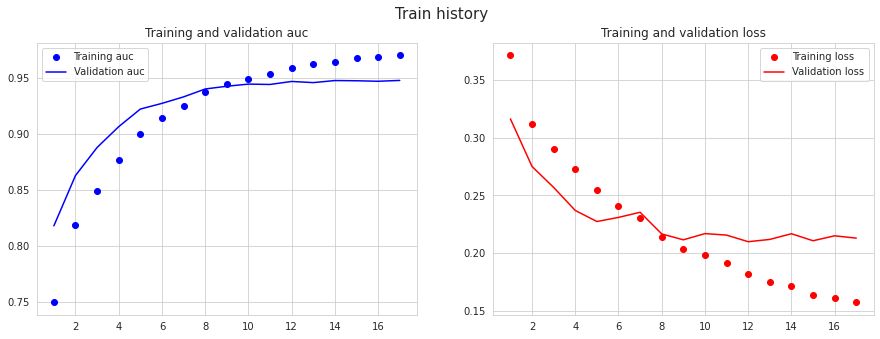

In [21]:
auc = history_list[0].history['auc']
val_auc = history_list[0].history['val_auc']
loss = history_list[0].history['loss']
val_loss = history_list[0].history['val_loss']

epochs = range(1, len(auc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, auc, "bo", label = "Training auc")
ax1.plot(epochs, val_auc, "b", label = "Validation auc")
ax1.set_title("Training and validation auc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

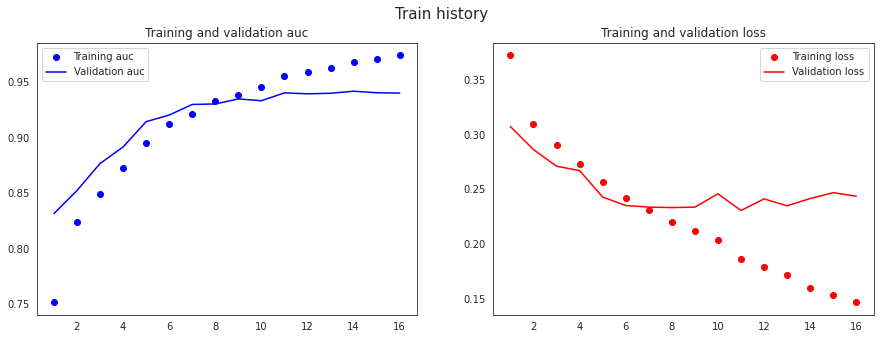

In [22]:
auc = history_list[1].history['auc']
val_auc = history_list[1].history['val_auc']
loss = history_list[1].history['loss']
val_loss = history_list[1].history['val_loss']

epochs = range(1, len(auc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, auc, "bo", label = "Training auc")
ax1.plot(epochs, val_auc, "b", label = "Validation auc")
ax1.set_title("Training and validation auc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

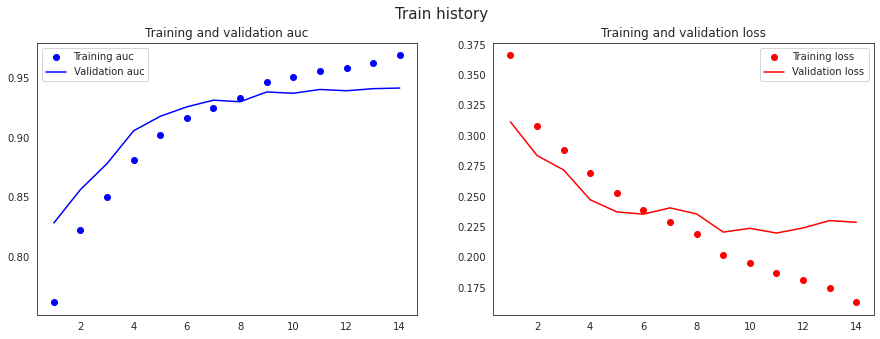

In [23]:
auc = history_list[2].history['auc']
val_auc = history_list[2].history['val_auc']
loss = history_list[2].history['loss']
val_loss = history_list[2].history['val_loss']

epochs = range(1, len(auc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, auc, "bo", label = "Training auc")
ax1.plot(epochs, val_auc, "b", label = "Validation auc")
ax1.set_title("Training and validation auc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

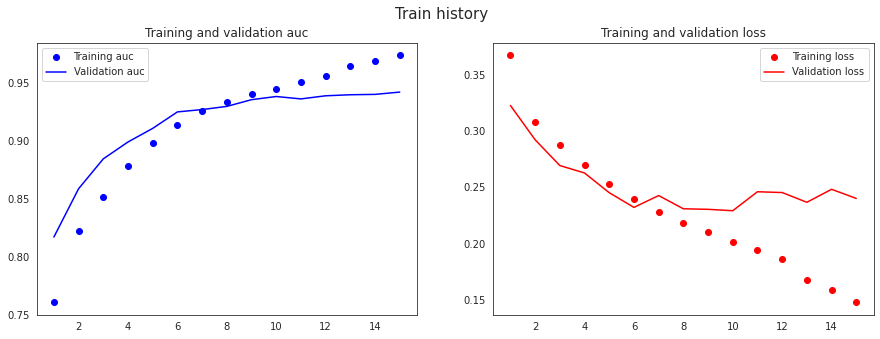

In [24]:
auc = history_list[3].history['auc']
val_auc = history_list[3].history['val_auc']
loss = history_list[3].history['loss']
val_loss = history_list[3].history['val_loss']

epochs = range(1, len(auc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, auc, "bo", label = "Training auc")
ax1.plot(epochs, val_auc, "b", label = "Validation auc")
ax1.set_title("Training and validation auc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

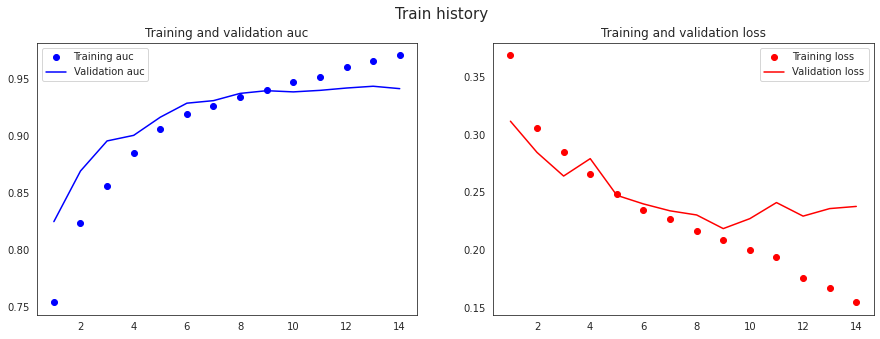

In [25]:
auc = history_list[4].history['auc']
val_auc = history_list[4].history['val_auc']
loss = history_list[4].history['loss']
val_loss = history_list[4].history['val_loss']

epochs = range(1, len(auc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, auc, "bo", label = "Training auc")
ax1.plot(epochs, val_auc, "b", label = "Validation auc")
ax1.set_title("Training and validation auc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

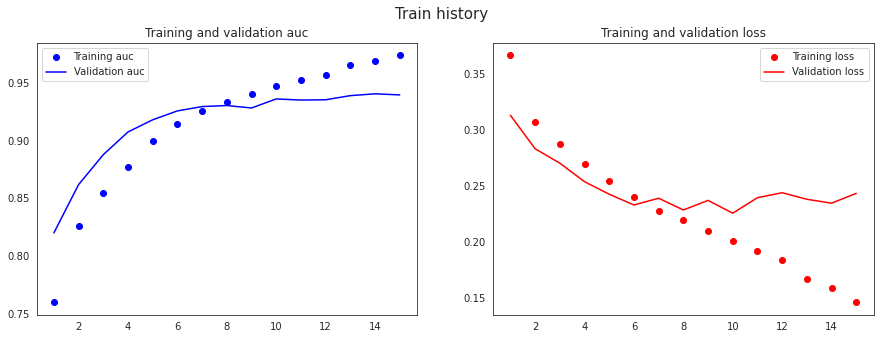

In [26]:
auc = history_list[5].history['auc']
val_auc = history_list[5].history['val_auc']
loss = history_list[5].history['loss']
val_loss = history_list[5].history['val_loss']

epochs = range(1, len(auc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, auc, "bo", label = "Training auc")
ax1.plot(epochs, val_auc, "b", label = "Validation auc")
ax1.set_title("Training and validation auc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

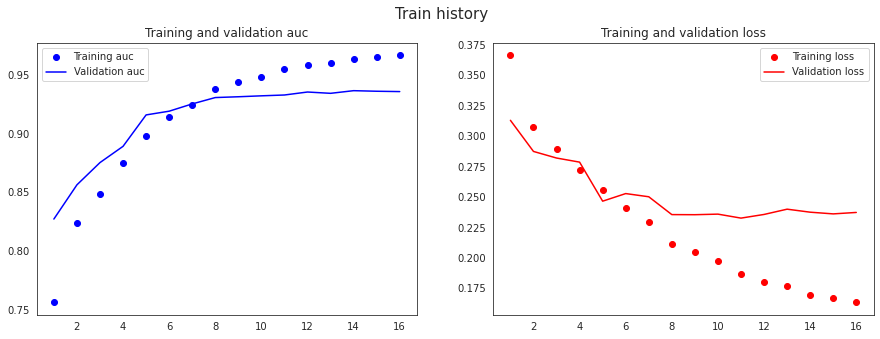

In [27]:
auc = history_list[6].history['auc']
val_auc = history_list[6].history['val_auc']
loss = history_list[6].history['loss']
val_loss = history_list[6].history['val_loss']

epochs = range(1, len(auc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, auc, "bo", label = "Training auc")
ax1.plot(epochs, val_auc, "b", label = "Validation auc")
ax1.set_title("Training and validation auc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()